# Fully Convolutional Neural Networks (FCNNs) - Denoising Example



In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Denoising FCNN

Develop a FCNN model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

- Data download link: https://drive.google.com/file/d/1O811Dsz8e_R2zfXVoeXMG2ZeayBUdoVn/view?usp=sharing


### 2.1 Load data  and split into train, validation, test

In [2]:
# Loading the data
data = np.load("../Data/denoising-1d/noisy_transients.npy")
target = np.load("../Data/denoising-1d/reference.npy")


# Shuffle the samples
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]


# Splitting the data into train/val/test
X_train = data[:int(data.shape[0]*0.8)]
Y_train = target[:int(data.shape[0]*0.8)]

X_val = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test = data[int(data.shape[0]*0.9):]
Y_test = target[int(data.shape[0]*0.9):]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [3]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())

-2.9169581831740183 3.7456143553633217 0.20930187888755594 0.7256459739784167


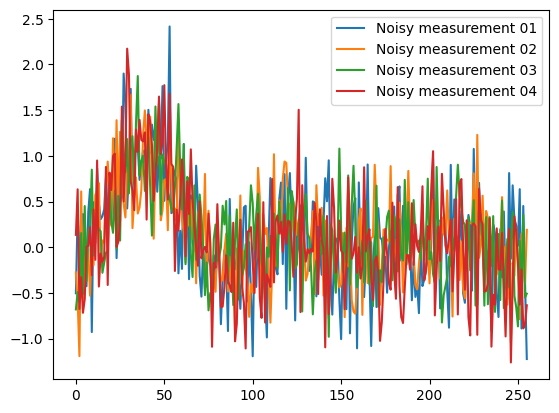

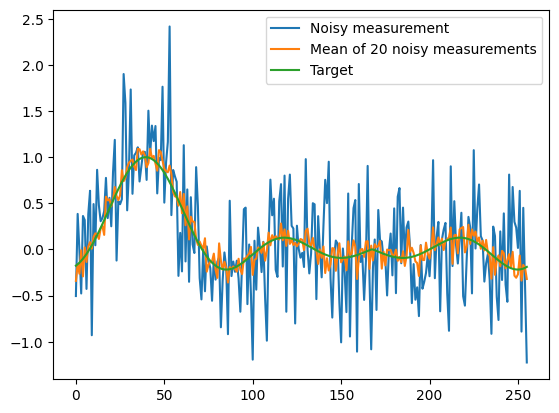

In [4]:
plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement 01")
plt.plot(X_train[0,:,1], label = "Noisy measurement 02")
plt.plot(X_train[0,:,2], label = "Noisy measurement 03")
plt.plot(X_train[0,:,3], label = "Noisy measurement 04")
plt.legend()
plt.show()

plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement")
plt.plot(X_train[0,:,:].mean(axis = -1), label = "Mean of 20 noisy measurements")
plt.plot(Y_train[0,:], label = "Target")
plt.legend()
plt.show()

### 2.3. Data scaling and Data augmentation

In [5]:
mean_train, std_train = X_train.mean(), X_train.std()

Xtrain_norm = (X_train - mean_train)/std_train 
Ytrain_norm = (Y_train - mean_train)/std_train

Xval_norm = (X_val - mean_train)/std_train
Yval_norm = (Y_val - mean_train)/std_train

Xtest_norm = (X_test - mean_train)/std_train
Ytest_norm = (Y_test - mean_train)/std_train

In [6]:
print(Xtrain_norm.min(),Xtrain_norm.max(),Xtrain_norm.mean(),Xtrain_norm.std())

-4.30824420470713 4.873330250959193 -1.5733299436933353e-16 1.0000000000000002


### 2.4. Define your  model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Fcnn_1d(nn.Module):
    
    def __init__(self, in_channels = 20):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels=60, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.out = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=1, padding=1) 
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.out(x)
        return x
        

In [77]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class Unet_1d(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding path
        self.block1 = UnetBlock(20, 60, 3)
        self.block2 = UnetBlock(60, 120, 3)
        self.block3 = UnetBlock(120, 240, 3)
        
        # Decoder Path
        self.block4 = UnetBlock(360, 120, 3)
        self.block5 = UnetBlock(180, 60, 3)
        self.out = nn.Conv1d(60, 1, 1)
    
    def forward(self, x):
        # Nx20x256
        out1 = self.block1(x)  # Nx60x256
        x = F.max_pool1d(out1, kernel_size=2, stride=2) # Nx60x128
        out2 = self.block2(x) # Nx120x128
        x = F.max_pool1d(out2, kernel_size=2, stride=2) # Nx120x64
        x = self.block3(x) # Nx240x64
        
        x = F.upsample(x, scale_factor=2) # Nx240x128
        print(x.shape)
        print(out2.shape)
        x = torch.concat([x,out2], dim=1) # Nx360x128
        x = self.block4(x)  # Nx120x128
        x = F.upsample(x, scale_factor=2)  # Nx120x256
        x = torch.concat([x,out1], dim=1) # Nx180x256
        x = self.block5(x) # Nx60x256
        out = self.out(x) # Nx1x256
        return out
    
unet = Unet_1d()
unet

Unet_1d(
  (block1): UnetBlock(
    (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block2): UnetBlock(
    (conv1): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block3): UnetBlock(
    (conv1): Conv1d(120, 240, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(240, 240, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block4): UnetBlock(
    (conv1): Conv1d(360, 120, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block5): UnetBlock(
    (conv1): Conv1d(180, 60, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

In [78]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loader(x,y,bs):
    # Permute np.array from NLC TO NCL
    x = torch.permute(torch.Tensor(x), dims=(0, 2, 1))
    y = torch.Tensor(y)
    return DataLoader(
        TensorDataset(x, y),
        batch_size=bs
    )

train_loader = get_data_loader(X_train, Y_train, 8)
val_loader = get_data_loader(X_val, Y_val, 8)
test_loader = get_data_loader(X_test, Y_test, 8)

for x,y in train_loader:
    break

print(x.shape)


torch.Size([8, 20, 256])


In [82]:
model = unet
model.train()
optim = torch.optim.Adam(params=model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

best_val_accuracy = -np.inf

for x,y in train_loader:
    break


In [83]:
y

tensor([[-0.1754, -0.1601, -0.1424,  ..., -0.2067, -0.1987, -0.1882],
        [-0.9570, -0.9519, -0.9461,  ..., -0.9690, -0.9656, -0.9616],
        [-0.1328, -0.1472, -0.1606,  ..., -0.0858, -0.1020, -0.1177],
        ...,
        [ 0.9209,  0.9110,  0.9006,  ...,  0.9472,  0.9390,  0.9302],
        [ 1.6140,  1.5729,  1.5310,  ...,  1.7300,  1.6927,  1.6540],
        [-0.0052, -0.0121, -0.0169,  ...,  0.0270,  0.0145,  0.0037]])

In [76]:
out.shape

torch.Size([8, 1, 256])

In [16]:
DataLoader()

TypeError: DataLoader.__init__() missing 1 required positional argument: 'dataset'

In [ ]:
train_loader = 

In [7]:
# Define your model here. 
def my_fcnn(ishape = (256,20),lr = 1e-3):
    input_layer = tf.keras.layers.Input(shape = ishape)
    conv1 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(input_layer)
    conv2 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv1)
    conv3 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv2)
    conv4 = tf.keras.layers.Conv1D(60,3,padding = "same", activation = 'relu')(conv3)
    out = tf.keras.layers.Conv1D(1,1, activation = 'linear')(conv4)
    model = tf.keras.models.Model(inputs = input_layer, outputs = out)
    return model

In [8]:
def my_unet(ishape = (256,20),lr = 1e-3):
    # Encoding path
    input_layer = tf.keras.layers.Input(shape = ishape)
    conv1 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(input_layer)
    conv2 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv1)
    mp1 = tf.keras.layers.MaxPool1D(2)(conv2)
    conv3 = tf.keras.layers.Conv1D(120,3, padding = "same", activation = 'relu')(mp1)
    conv4 = tf.keras.layers.Conv1D(120,3,padding = "same", activation = 'relu')(conv3)
    mp2 = tf.keras.layers.MaxPool1D(2)(conv4)
    conv5 = tf.keras.layers.Conv1D(240,3, padding = "same", activation = 'relu')(mp2)
    conv6 = tf.keras.layers.Conv1D(240,3,padding = "same", activation = 'relu')(conv5)
    
    
    # Decoding path
    up1 = tf.keras.layers.UpSampling1D(2)(conv6) # unpooling
    concat1 = tf.keras.layers.Concatenate(axis = -1)([up1,conv4]) # skip-connection in the diagram
    conv7 = tf.keras.layers.Conv1D(120,3, padding = "same", activation = 'relu')(concat1)
    conv8 = tf.keras.layers.Conv1D(120,3,padding = "same", activation = 'relu')(conv7)
    up2 = tf.keras.layers.UpSampling1D(2)(conv8) # unpooling
    concat2 = tf.keras.layers.Concatenate(axis = -1)([up2,conv2]) # skip-connection in the diagram
    conv9 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(concat2)
    conv10 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv9)
    out = tf.keras.layers.Conv1D(1,1, activation = 'linear')(conv10) # 1x1 convolution
    model = tf.keras.models.Model(inputs = input_layer, outputs = out)
    return model

### 2.5. Define your callbacks (save your model, patience, etc.)

In [9]:
model_name = "../Data/best_model_unet_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [10]:
model = my_unet()
print(model.summary())

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mse")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 20)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 60)      3660        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 60)      10860       conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 60)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

### 2.6. Train your model

In [11]:
# train your model - decide for how many epochs
model.fit(Xtrain_norm,Ytrain_norm,batch_size = 8, epochs = 10, verbose = 1,\
          validation_data = (Xval_norm,Yval_norm),callbacks =  [early_stop, monitor, lr_schedule], shuffle = True )

Epoch 1/10
27/27 [==============================] - 67s 778ms/step - loss: 0.1523 - val_loss: 0.0114
Epoch 2/10
27/27 [==============================] - 1s 29ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 3/10
27/27 [==============================] - 1s 30ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 4/10
27/27 [==============================] - 1s 30ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 5/10
27/27 [==============================] - 1s 31ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/10
27/27 [==============================] - 1s 31ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/10
27/27 [==============================] - 1s 29ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 9/10
27/27 [==============================] - 1s 29ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/10
27/27 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0022


### 2.7. Test your model

In [12]:
model.load_weights(model_name)
Ypred = model.predict(Xtest_norm)[:,:,0]

Ymean = Xtest_norm.mean(axis = -1)

In [14]:
# Remember to "unscale your data".
print("FCNN MSE:")
print(((Ypred - Ytest_norm)**2).mean())
print("Mean MSE:")
print(((Ymean - Ytest_norm)**2).mean())

FCNN MSE:
0.00238621849889961
Mean MSE:
0.017835806056922792


In [15]:
Ymean_unscaled = Ymean*std_train + mean_train
Ypred_unscaled = Ypred*std_train + mean_train

(27, 256)
(27, 256)
(27, 256)


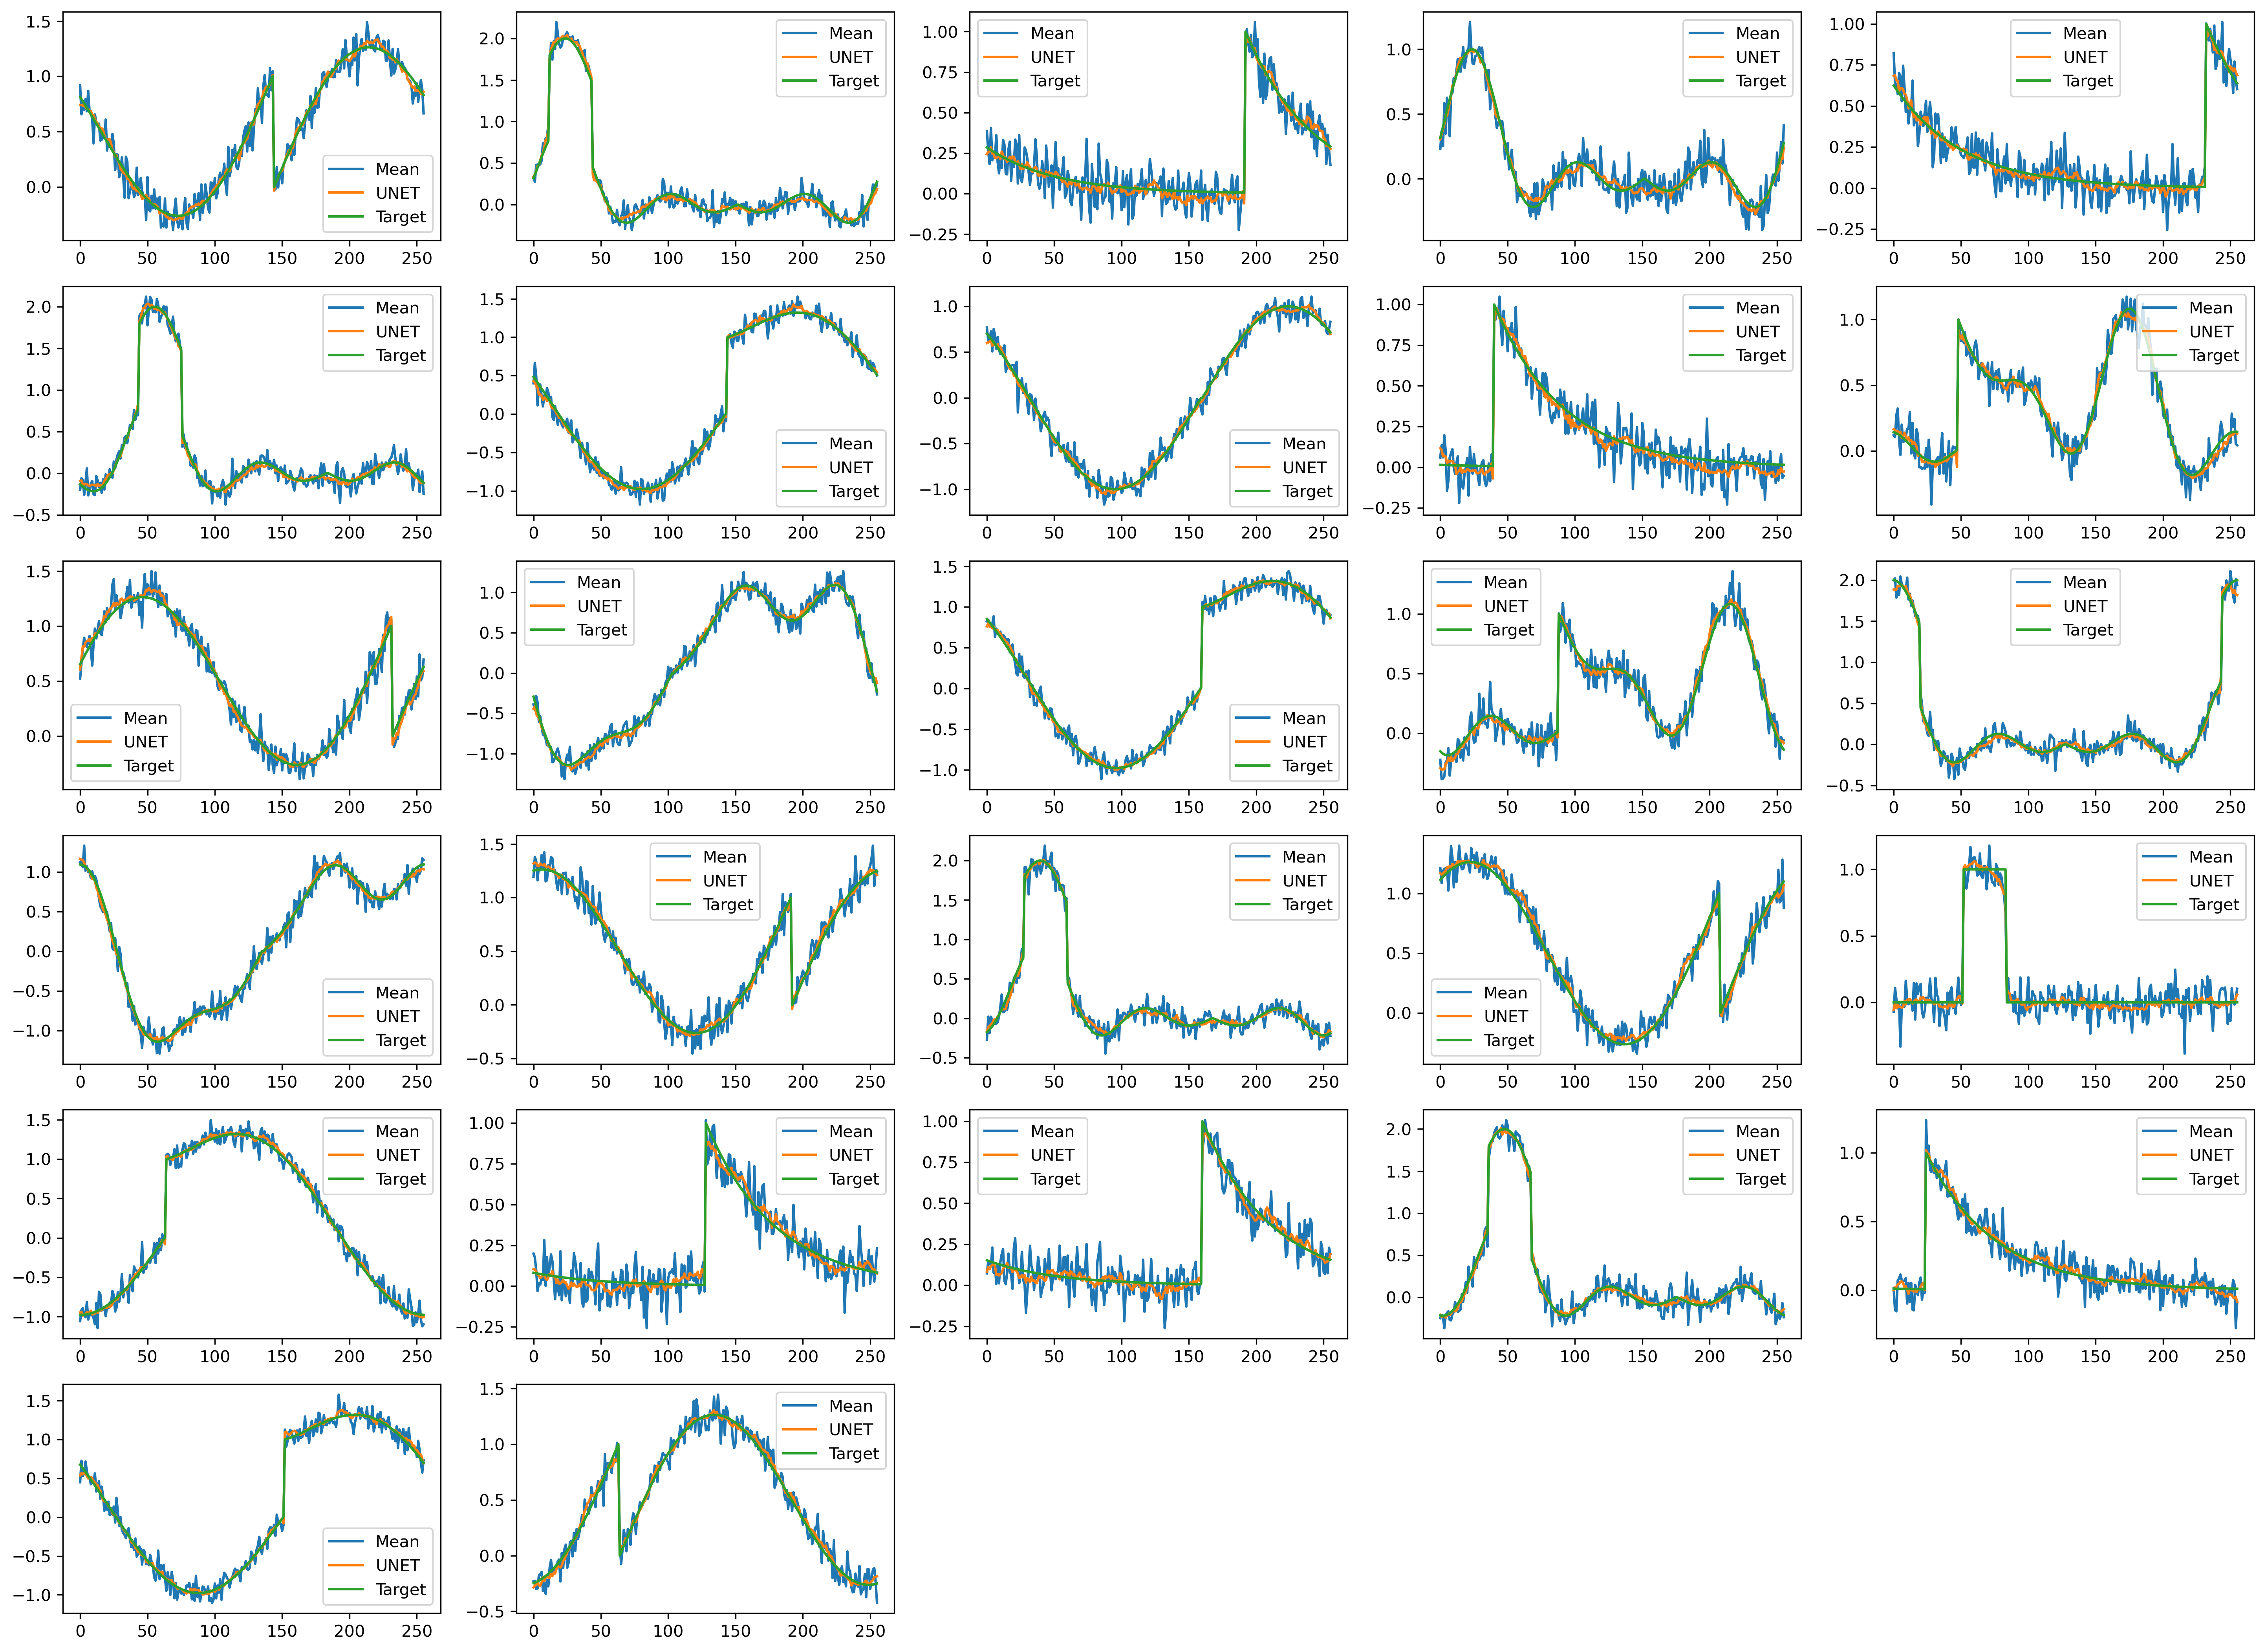

In [20]:
print(Ymean_unscaled.shape)
print(Ypred_unscaled.shape)
print(Y_test.shape)
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    #plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean_unscaled[ii], label = "Mean")
    plt.plot(Ypred_unscaled[ii], label = "UNET")
    plt.plot(Y_test[ii], label = "Target")
    plt.legend()
plt.show()